In [1]:
import os

from collections import defaultdict, deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [12]:
data_dir = "."

# https://mbta-massdot.opendata.arcgis.com/datasets/mbta-rapid-transit-travel-times-2020/about
# Note that this data is currently not checked into the repo since the files are very large
# (~1GB per quarter). Instead the pre-computed summaries are stored in the repo.
# travel_times_dir = os.path.join(data_dir, "TravelTimes_2023")

# https://github.com/mbta/gtfs-documentation/blob/master/reference/gtfs.md#stopstxt
# but with bus stops removed to reduce file size for checking into repo.
stops_path = os.path.join(data_dir, "gtfs", "stops_no_bus.csv")

# A non-trivial amount of stops in `stops.txt` don't have a zipcode included in their address
# so I manually joined in the zip codes using QGIS and wrote them out here.
stops_zip_path = os.path.join(data_dir, "gtfs", "MBTA_Systemwide_GTFS_Map_stops_w_zip.csv")
cr_stops_zip_path = os.path.join(data_dir, "gtfs", "MBTA_Systemwide_GTFS_Map_cr_stops_w_zip.csv")

# https://mbta-massdot.opendata.arcgis.com/datasets/3b93de20570f462ea27219dfb7e75347_0/explore
commuter_rail_path = os.path.join(data_dir, "MBTA_Commuter_Rail_Ridership_by_Trip_Season_Route_Line_and_Stop.csv")

## Commuter rail

In [3]:
cr = pd.read_csv(commuter_rail_path)
print(cr.shape)
cr.head()

(9988, 14)


,season,route_id,route_name,train,direction_id,day_type_id,day_type_name,stop_time,stop_id,stopsequence,average_ons,average_offs,average_load,ObjectId
0,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 11:35:00+00,Readville,4,11.0,NaN,11.0,1
1,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 11:38:00+00,Fairmount,5,19.0,0.0,30.0,2
2,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 11:42:00+00,Morton Street,6,8.0,0.0,38.0,3
3,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 11:49:00+00,Uphams Corner,7,7.0,1.0,44.0,4
4,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 12:02:00+00,South Station,8,NaN,44.0,NaN,5


In [4]:
cr.season.value_counts()

season
Spring 2018    5376
Spring 2012    4612
Name: count, dtype: int64

In [5]:
cr = (cr
      .query("season == 'Spring 2018'")
      .assign(stop_time_dt=lambda x: pd.to_datetime(x.stop_time)))
cr.head()

,season,route_id,route_name,train,direction_id,day_type_id,day_type_name,stop_time,stop_id,stopsequence,average_ons,average_offs,average_load,ObjectId,stop_time_dt
4450,Spring 2018,CR-Fairmount,Fairmount Line,770,1,day_type_01,weekday,2018/01/01 20:30:00+00,Readville,1,28.0,NaN,28.0,4451,2018-01-01 20:30:00+00:00
4451,Spring 2018,CR-Fairmount,Fairmount Line,770,1,day_type_01,weekday,2018/01/01 20:33:00+00,Fairmount,2,11.0,5.0,34.0,4452,2018-01-01 20:33:00+00:00
4452,Spring 2018,CR-Fairmount,Fairmount Line,770,1,day_type_01,weekday,2018/01/01 20:38:00+00,Morton Street,3,28.0,6.0,56.0,4453,2018-01-01 20:38:00+00:00
4453,Spring 2018,CR-Fairmount,Fairmount Line,770,1,day_type_01,weekday,2018/01/01 20:41:00+00,Talbot Avenue,4,5.0,7.0,54.0,4454,2018-01-01 20:41:00+00:00
4454,Spring 2018,CR-Fairmount,Fairmount Line,770,1,day_type_01,weekday,2018/01/01 20:44:00+00,Four Corners / Geneva,5,11.0,20.0,45.0,4455,2018-01-01 20:44:00+00:00


In [6]:
def get_train_times(train_df):
    train_df = train_df.sort_values("stopsequence")
    iter_cols = ["stop_id", "stop_time_dt", "stopsequence"]
    (from_stop, from_time, from_seq) = train_df[iter_cols].iloc[0]

    times = []
    for (stop, time, seq_id) in train_df[iter_cols].iloc[1:].itertuples(index=False):
        if seq_id <= from_seq:
            raise ValueError(f"unexpected seq IDs: {from_seq} -> {seq_id} ({from_stop} -> {stop})")

        times.append({
            "from_stop_id": from_stop,
            "to_stop_id": stop,
            "travel_time_sec": (time - from_time).total_seconds(),
        })
        from_stop = stop
        from_time = time
        from_seq = seq_id
    return pd.DataFrame(times)

def get_route_times(route_df):
    return (route_df
            .groupby("train")
            .apply(get_train_times)
            .reset_index()
            .drop(columns="level_1"))

def get_all_cr_times(df):
    return (df
            .groupby("route_id")
            .apply(get_route_times)
            .reset_index()
            .drop(columns="level_1"))


In [7]:
cr_times = get_all_cr_times(cr)
print(len(cr_times))
cr_times.head()

4860


,route_id,train,from_stop_id,to_stop_id,travel_time_sec
0,CR-Fairmount,746,Readville,Fairmount,180.0
1,CR-Fairmount,746,Fairmount,Morton Street,300.0
2,CR-Fairmount,746,Morton Street,Talbot Avenue,180.0
3,CR-Fairmount,746,Talbot Avenue,Four Corners / Geneva,180.0
4,CR-Fairmount,746,Four Corners / Geneva,Uphams Corner,180.0


In [8]:
cr_times_for_routes = (cr_times
                       .drop_duplicates(["from_stop_id", "to_stop_id"])
                       .drop(columns=["travel_time_sec", "train"]))
cr_times_for_routes.head()

,route_id,from_stop_id,to_stop_id
0,CR-Fairmount,Readville,Fairmount
1,CR-Fairmount,Fairmount,Morton Street
2,CR-Fairmount,Morton Street,Talbot Avenue
3,CR-Fairmount,Talbot Avenue,Four Corners / Geneva
4,CR-Fairmount,Four Corners / Geneva,Uphams Corner


In [9]:
cr_time_summaries = (cr_times
                     .groupby(["from_stop_id", "to_stop_id"])
                     .travel_time_sec
                     .describe()
                     .reset_index()
                     .merge(cr_times_for_routes, on =["from_stop_id", "to_stop_id"])
                     .rename(columns={"50%": "median_time"})
                     [["route_id", "from_stop_id", "to_stop_id", "median_time", "count"]])
print(len(cr_time_summaries))
cr_time_summaries.head()

378


,route_id,from_stop_id,to_stop_id,median_time,count
0,CR-Kingston,Abington,South Weymouth,300.0,12.0
1,CR-Kingston,Abington,Whitman,240.0,12.0
2,CR-Lowell,Anderson/ Woburn,Lowell,900.0,1.0
3,CR-Lowell,Anderson/ Woburn,Mishawum,60.0,3.0
4,CR-Lowell,Anderson/ Woburn,North Station,1200.0,2.0


## Stops

In [13]:
stops = pd.read_csv(stops_path)
stops.head()

,stop_id,stop_code,stop_name,stop_desc,platform_code,platform_name,stop_lat,stop_lon,zone_id,stop_address,stop_url,level_id,location_type,parent_station,wheelchair_boarding,municipality,on_street,at_street,vehicle_type
0,1,1,Washington St opp Ruggles St,NaN,NaN,NaN,42.330957,-71.082754,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/1,NaN,0,NaN,1,Boston,Washington Street,Ruggles Street,3.0
1,11384,11384,Dartmouth St @ Back Bay Sta,NaN,NaN,NaN,42.347346,-71.075956,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/11384,NaN,0,NaN,1,Boston,Dartmouth Street,Stuart Street,3.0
2,117,117,Congress St @ Haymarket Sta,NaN,NaN,NaN,42.361847,-71.057724,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/117,NaN,0,NaN,1,Boston,Congress Street,Hanover Street,3.0
3,1389,1389,Boylston St @ Prudential Center,NaN,NaN,NaN,42.348631,-71.082561,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/1389,NaN,0,NaN,1,Boston,Boylston Street,Fairfield Street,3.0
4,1395,1395,Dartmouth St @ Appleton St,NaN,NaN,NaN,42.345156,-71.074969,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/1395,NaN,0,NaN,1,Boston,Dartmouth Street,Appleton Street,3.0


In [14]:
# `zone_id` seems to be the most human-readable column describing what type of transit
# a given stop corresponds to. No documentation for `vehicle_type` online. Many
# NaNs in `zone_id`
stops.zone_id.value_counts(dropna=False)

zone_id
NaN                     2320
RapidTransit             277
CR-zone-1A                97
CR-zone-2                 75
CR-zone-3                 62
CR-zone-4                 50
CR-zone-1                 44
CR-zone-8                 44
ExpressBus-Downtown       43
CR-zone-5                 40
CR-zone-6                 38
CR-zone-7                 36
SLWaterfrontNonLogan      19
CF-zone-buzzards           6
SL1-Logan                  5
Boat-Long                  3
Boat-zone-1A               3
CR-zone-9                  2
CR-zone-10                 2
CF-zone-hyannis            2
Boat-Aquarium              1
Boat-Hull                  1
Boat-Lewis                 1
Boat-George                1
Boat-Hingham               1
Boat-Rowes                 1
Boat-Logan                 1
Boat-Fan                   1
Name: count, dtype: int64

In [15]:
# What do the NaN `zone_id` rows correspond to?
stops.loc[lambda x: x.zone_id.isna()].vehicle_type.value_counts()

vehicle_type
3.0    247
4.0      1
Name: count, dtype: int64

In [16]:
stops.loc[lambda x: x.vehicle_type == 3].head()

,stop_id,stop_code,stop_name,stop_desc,platform_code,platform_name,stop_lat,stop_lon,zone_id,stop_address,stop_url,level_id,location_type,parent_station,wheelchair_boarding,municipality,on_street,at_street,vehicle_type
0,1,1,Washington St opp Ruggles St,NaN,NaN,NaN,42.330957,-71.082754,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/1,NaN,0,NaN,1,Boston,Washington Street,Ruggles Street,3.0
1,11384,11384,Dartmouth St @ Back Bay Sta,NaN,NaN,NaN,42.347346,-71.075956,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/11384,NaN,0,NaN,1,Boston,Dartmouth Street,Stuart Street,3.0
2,117,117,Congress St @ Haymarket Sta,NaN,NaN,NaN,42.361847,-71.057724,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/117,NaN,0,NaN,1,Boston,Congress Street,Hanover Street,3.0
3,1389,1389,Boylston St @ Prudential Center,NaN,NaN,NaN,42.348631,-71.082561,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/1389,NaN,0,NaN,1,Boston,Boylston Street,Fairfield Street,3.0
4,1395,1395,Dartmouth St @ Appleton St,NaN,NaN,NaN,42.345156,-71.074969,ExpressBus-Downtown,NaN,https://www.mbta.com/stops/1395,NaN,0,NaN,1,Boston,Dartmouth Street,Appleton Street,3.0


In [17]:
stops.loc[lambda x: x.vehicle_type == 4].head()

,stop_id,stop_code,stop_name,stop_desc,platform_code,platform_name,stop_lat,stop_lon,zone_id,stop_address,stop_url,level_id,location_type,parent_station,wheelchair_boarding,municipality,on_street,at_street,vehicle_type
177,Boat-Aquarium,NaN,Central Wharf (South),Central Wharf (South) - Winthrop Ferry,NaN,Winthrop Ferry,42.358815,-71.048779,Boat-Aquarium,"Central Wharf near Milk St, Boston, MA 02110",https://www.mbta.com/stops/Boat-Aquarium,NaN,0,NaN,1,Boston,NaN,NaN,4.0
178,Boat-Blossom,NaN,Blossom Street Pier,Blossom Street Pier - Lynn Ferry,NaN,Lynn Ferry,42.454810,-70.948020,Boat-zone-1A,"379 Blossom St Ext, Lynn, MA 01905",https://www.mbta.com/stops/Boat-Blossom,NaN,0,NaN,1,Lynn,NaN,NaN,4.0
179,Boat-Charlestown,NaN,Charlestown Navy Yard,Charlestown Navy Yard - Charlestown Ferry,NaN,Charlestown Ferry,42.372756,-71.052528,NaN,"Pier 4, Boston, MA 02129",https://www.mbta.com/stops/Boat-Charlestown,NaN,0,NaN,1,Boston,NaN,NaN,4.0
180,Boat-Fan,NaN,Seaport/Fan Pier,Seaport/Fan Pier - Winthrop Ferry,NaN,Winthrop Ferry,42.353484,-71.043230,Boat-Fan,Fan Pier Marina near Institute of Contemporary...,https://www.mbta.com/stops/Boat-Fan,NaN,0,NaN,1,Boston,NaN,NaN,4.0
181,Boat-George,NaN,Georges Island,Georges Island - Hingham/Hull Ferry,NaN,Hingham/Hull Ferry,42.319742,-70.930427,Boat-George,"George's Island, Boston, MA",https://www.mbta.com/stops/Boat-George,NaN,0,NaN,1,Boston,NaN,NaN,4.0


In [18]:
# Looks like they're all either bus or boat ferry stops, which we
# won't be looking at, so we'll remove the NaNs.
stops_filt = stops.loc[lambda x: ~x.zone_id.isna()]
len(stops_filt)

856

In [19]:
# Looks like we can get rapid transit (i.e. subway) from `zone_id`,
# but multiple different zones for commuter rail.
cr_stops  = stops_filt.loc[lambda x: x.zone_id.str.contains("CR")]
print(len(cr_stops))
cr_stops.vehicle_type.isna().value_counts()

490


vehicle_type
False    346
True     144
Name: count, dtype: int64

In [20]:
rt_stops = stops.query("zone_id == 'RapidTransit'")
rt_stops.head()

,stop_id,stop_code,stop_name,stop_desc,platform_code,platform_name,stop_lat,stop_lon,zone_id,stop_address,stop_url,level_id,location_type,parent_station,wheelchair_boarding,municipality,on_street,at_street,vehicle_type
755,70061,70061,Alewife,Alewife - Red Line,NaN,Red Line,42.396158,-71.139971,RapidTransit,NaN,https://www.mbta.com/stops/place-alfcl,level_-2_platform,0,place-alfcl,1,Cambridge,NaN,NaN,1.0
756,Alewife-01,NaN,Alewife,Alewife - Red Line - Track 1,1,Track 1,42.396158,-71.139971,RapidTransit,NaN,https://www.mbta.com/stops/place-alfcl,level_-2_platform,0,place-alfcl,1,Cambridge,NaN,NaN,1.0
757,Alewife-02,NaN,Alewife,Alewife - Red Line - Track 2,2,Track 2,42.396158,-71.139971,RapidTransit,NaN,https://www.mbta.com/stops/place-alfcl,level_-2_platform,0,place-alfcl,1,Cambridge,NaN,NaN,1.0
765,70126,70126,Allston Street,Allston Street - Green Line - Park Street & North,NaN,Park Street & North,42.348649,-71.137881,RapidTransit,NaN,https://www.mbta.com/stops/place-alsgr,level_median,0,place-alsgr,2,Boston,NaN,NaN,0.0
766,70127,70127,Allston Street,Allston Street - Green Line - (B) Boston College,NaN,Boston College,42.348546,-71.137362,RapidTransit,NaN,https://www.mbta.com/stops/place-alsgr,level_median,0,place-alsgr,2,Boston,NaN,NaN,0.0


In [21]:
stops_by_station = (rt_stops
                    .loc[lambda x: x.stop_id.str.match("\d+")]
                    .groupby("parent_station").stop_id.apply(lambda x: x.tolist()))
# Convert to dict for easier adding of commuter rail stops
stops_by_station_map = defaultdict(list)
stops_by_station_map.update(stops_by_station.to_dict())
stops_by_station_map

defaultdict(list,
            {'place-alfcl': ['70061'],
             'place-alsgr': ['70126', '70127'],
             'place-amory': ['170140', '170141'],
             'place-andrw': ['70083', '70084'],
             'place-aport': ['70047', '70048'],
             'place-aqucl': ['70043', '70044'],
             'place-armnl': ['70156', '70157'],
             'place-asmnl': ['70093', '70094', '70261'],
             'place-astao': ['70278', '70279'],
             'place-babck': ['170136', '170137'],
             'place-balsq': ['70509', '70510'],
             'place-bbsta': ['70014', '70015'],
             'place-bckhl': ['70257', '70258'],
             'place-bcnfd': ['70176', '70177'],
             'place-bcnwa': ['70229', '70230'],
             'place-bland': ['70148', '70149'],
             'place-bmmnl': ['70055', '70056'],
             'place-bndhl': ['70225', '70226'],
             'place-bomnl': ['70038', '70838'],
             'place-boyls': ['70158', '70159'],
             'plac

In [22]:
# Commuter rail stops have multiple rows per station, one per platform and then
# also two overarching entries. We want the overarching entry per station
# that is in the same format as the other stop IDs (i.e. not parent station)
# The series of queries below were the simplest way I could find for pulling
# these out.
canonical_cr_stops = (cr_stops
                      .loc[lambda x: ~x.platform_name.isna()]
                      .loc[lambda x: (x.platform_name == "Commuter Rail") | x.platform_name.str.contains("All Trains")])
print(len(canonical_cr_stops))
canonical_cr_stops.head()

144


,stop_id,stop_code,stop_name,stop_desc,platform_code,platform_name,stop_lat,stop_lon,zone_id,stop_address,stop_url,level_id,location_type,parent_station,wheelchair_boarding,municipality,on_street,at_street,vehicle_type
201,DB-0095,NaN,Readville,Readville - Commuter Rail,NaN,Commuter Rail,42.238405,-71.133246,CR-zone-2,NaN,https://www.mbta.com/stops/place-DB-0095,NaN,0,place-DB-0095,1,Boston,NaN,NaN,2.0
208,DB-2205,NaN,Fairmount,Fairmount - Commuter Rail,NaN,Commuter Rail,42.253638,-71.119270,CR-zone-1A,NaN,https://www.mbta.com/stops/place-DB-2205,NaN,0,place-DB-2205,1,Boston,NaN,NaN,2.0
214,DB-2222,NaN,Blue Hill Avenue,Blue Hill Avenue - Commuter Rail,NaN,Commuter Rail,42.271466,-71.095782,CR-zone-1A,NaN,https://www.mbta.com/stops/place-DB-2222,NaN,0,place-DB-2222,1,Boston,NaN,NaN,2.0
220,DB-2230,NaN,Morton Street,Morton Street - Commuter Rail,NaN,Commuter Rail,42.280994,-71.085475,CR-zone-1A,NaN,https://www.mbta.com/stops/place-DB-2230,NaN,0,place-DB-2230,1,Boston,NaN,NaN,2.0
226,DB-2240,NaN,Talbot Avenue,Talbot Avenue - Commuter Rail,NaN,Commuter Rail,42.292246,-71.078140,CR-zone-1A,NaN,https://www.mbta.com/stops/place-DB-2240,NaN,0,place-DB-2240,1,Boston,NaN,NaN,2.0


In [23]:
cr_to_stop_id_map = {name:stop_id for (stop_id, name) in canonical_cr_stops[["stop_id", "stop_name"]].itertuples(index=False)}
# Need to supplement this with some hand-curated mappings for
# stations with inconsistent namings.
extra_namings = {
    "Dedham Corp Center": "Dedham Corporate Center",
    "JFK/UMASS": "JFK/UMass",
    "Littleton/Rte 495": "Littleton/Route 495",
    "Melrose Cedar Park": "Melrose/Cedar Park",
    "Porter Square": "Porter",
    "River Works/GE Employees Only": "River Works",
    "Yawkey": "Lansdowne",
}

def map_cr_stop(x):
    return (x
            .str.replace("\s*/\s*", "/", regex=True)
            .apply(lambda x: extra_namings.get(x, x))
            .apply(cr_to_stop_id_map.get))


cr_time_summaries = (cr_time_summaries
                     .assign(
                         from_db_name=lambda x: map_cr_stop(x.from_stop_id),
                         to_db_name=lambda x: map_cr_stop(x.to_stop_id),
                     ))
cr_time_summaries.head()

,route_id,from_stop_id,to_stop_id,median_time,count,from_db_name,to_db_name
0,CR-Kingston,Abington,South Weymouth,300.0,12.0,PB-0194-S,PB-0158-S
1,CR-Kingston,Abington,Whitman,240.0,12.0,PB-0194-S,PB-0212-S
2,CR-Lowell,Anderson/ Woburn,Lowell,900.0,1.0,NHRML-0127,NHRML-0254
3,CR-Lowell,Anderson/ Woburn,Mishawum,60.0,3.0,NHRML-0127,NHRML-0116
4,CR-Lowell,Anderson/ Woburn,North Station,1200.0,2.0,NHRML-0127,BNT-0000


In [24]:
stops_by_station["place-portr"]

['70065', '70066']

In [25]:
len(stops_by_station)

125

In [26]:
stops_by_station

parent_station
place-alfcl             [70061]
place-alsgr      [70126, 70127]
place-amory    [170140, 170141]
place-andrw      [70083, 70084]
place-aport      [70047, 70048]
                     ...       
place-wimnl      [70049, 70050]
place-wlsta      [70099, 70100]
place-wondl      [70059, 70060]
place-woodl      [70162, 70163]
place-wrnst      [70124, 70125]
Name: stop_id, Length: 125, dtype: object

In [27]:
# Add in commuter rail stops.
for val in cr_time_summaries.from_db_name.unique():
    want = stops_filt.query("stop_id == @val")
    stops_by_station_map[want.parent_station.iat[0]].append(val)

In [28]:
stops_by_station_map["place-portr"]

['70065', '70066', 'FR-0034']

In [29]:
len(stops_by_station_map)

254

In [30]:
station_map = {}
for (parent, this_stops) in stops_by_station_map.items():
    for stop_id in this_stops:
        if stop_id in station_map:
            raise ValueError(f"station occurs twice: {stop_id}")
        station_map[stop_id] = parent

In [31]:
station_map["FR-0034"]

'place-portr'

In [32]:
station_map["NHRML-0127"]

'place-NHRML-0127'

In [33]:
stops_zip = (pd.read_csv(stops_zip_path, dtype={"POSTCODE": str})
             [["stop_id", "POSTCODE"]]
             .rename(columns={"POSTCODE": "zipcode"}))
print(stops_zip.shape)
stops_zip.head()

(127, 2)


,stop_id,zipcode
0,place-alfcl,02140
1,place-alsgr,02134
2,place-amory,02215
3,place-andrw,02127
4,place-aport,02128


In [34]:
cr_stops_zip = (pd.read_csv(cr_stops_zip_path, dtype={"POSTCODE": str})
                [["stop_id", "POSTCODE"]]
                .rename(columns={"POSTCODE": "zipcode"})
                .assign(
                    # Get the part of the stop ID that matches the `stops.txt` file.
                    stop_id=lambda x: "place-" + x.stop_id.str.extract("([A-Z]+-\d+)", expand=False)
                )
                .drop_duplicates("stop_id"))

print(cr_stops_zip.shape)
cr_stops_zip.head()

(151, 2)


,stop_id,zipcode
0,place-CM-0493,02571
1,place-CM-0547,02532
2,place-CM-0564,02532
3,place-CM-0790,02601
4,place-DB-0095,02136


In [35]:
stops_zip = pd.concat((stops_zip, cr_stops_zip))
len(stops_zip)

278

## Travel times

### Compute average travel times on rapid transit

Note that you'll need to download this data locally to run these cells, but the pre-computed data is stored alongside this notebook in the repo.

In [34]:
qs = [f"Q{i}" for i in range(1, 5)]
rails = ["HR", "LR"]

def read_data(quarter: str , rail: str) -> pd.DataFrame:
    return pd.read_csv(os.path.join(travel_times_dir, f"2023-{quarter}_{rail}TravelTimes.csv"))

def update_stats(lhs, rhs):
    if lhs is None:
        return rhs
    return (lhs
            .merge(rhs, on=["from_stop_id", "to_stop_id"], suffixes=("_lhs", "_rhs"))
            .assign(
                count=lambda x: x.count_lhs+x.count_rhs,
                mean=lambda x: x.mean_lhs * (x.count_lhs / x["count"]) + x.mean_rhs * (x.count_rhs / x["count"]),
            )
            [["from_stop_id", "to_stop_id", "count", "mean"]])

def avg_over_qs(rail):
    avgs = None
    for q in qs:
        q_avgs = (read_data(q, rail)
                  .groupby(["from_stop_id", "to_stop_id"])
                  .travel_time_sec
                  .describe()
                  .reset_index()
                  [["from_stop_id", "to_stop_id", "count", "mean"]])
        avgs = update_stats(avgs, q_avgs)
    return avgs



In [35]:
lr_travel_times = avg_over_qs("LR")
lr_travel_times.head()

,from_stop_id,to_stop_id,count,mean
0,70106,70110,39814.0,106.790375
1,70106,70112,38668.0,229.668692
2,70106,70114,38663.0,303.116985
3,70106,70116,38657.0,382.721292
4,70106,70120,38559.0,502.457818


In [36]:
len(lr_travel_times)

2681

In [37]:
# For some reason there are no documented trips from Cedar Grove to
# Ashmont, despite there being many trips along the Mattapan trolley
# line, including trips from Ashmont to Cedar Grove. Manually add
# in this connection.
dupe = (lr_travel_times
        .query("from_stop_id == 70261 and to_stop_id == 70263")
        .assign(
            from_stop_id=70264,
            to_stop_id=70261,
        ))
lr_travel_times = pd.concat((lr_travel_times, dupe), ignore_index=True)

In [38]:
hr_travel_times = avg_over_qs("HR")
hr_travel_times.head()

,from_stop_id,to_stop_id,count,mean
0,70001,70003,38175.0,96.166889
1,70001,70005,38149.0,205.610160
2,70001,70007,38145.0,332.502032
3,70001,70009,38132.0,445.824609
4,70001,70011,38095.0,553.542433


In [39]:
# All rapid transit time summaries
rt_travel_times = pd.concat([lr_travel_times, hr_travel_times])
len(rt_travel_times)

3629

In [53]:
with open(os.path.join(data_dir, "rt_travel_summaries.tsv"), "w") as fh:
    rt_travel_times.to_csv(fh, sep="\t", index=False)

### Construct graph

In [36]:
with open(os.path.join(data_dir, "rt_travel_summaries.tsv")) as fh:
    rt_travel_times = pd.read_table(fh, sep="\t")

In [37]:
def construct_travel_graph(rt_time_summaries, id_to_station_map):
    graph = defaultdict(dict)
    tuples = (rt_time_summaries
              [["from_stop_id", "to_stop_id", "mean"]]
              .astype({"from_stop_id": str, "to_stop_id": str})
              .itertuples(index=False))
    for (from_id, to_id, time) in tuples:
        from_station = id_to_station_map[from_id]
        to_station = id_to_station_map[to_id]

        graph[from_station][to_station] = time
    return graph

def augment_graph_w_commuter_rail(graph, cr_times, id_to_station_map):
    tuples = (cr_times
              [["from_db_name", "to_db_name", "median_time"]]
              .itertuples(index=False))
    for (from_id, to_id, time) in tuples:
        from_station = id_to_station_map.get(from_id, from_id)
        to_station = id_to_station_map.get(to_id, to_id)
        graph[from_station][to_station] = time

In [38]:
graph = construct_travel_graph(rt_travel_times, station_map)
augment_graph_w_commuter_rail(graph, cr_time_summaries, station_map)

In [39]:
def populate_dists_bfs(graph, root):
    dists = {}
    queue = deque([(x, t, [x]) for (x, t) in graph[root].items()])

    while len(queue) != 0:
        station, time, route = queue.popleft()
        if station in dists:
            continue
        dists[station] = (time, route)
        for neighbor, neighbor_time in graph[station].items():
            new_route = route.copy()
            new_route.append(neighbor)
            queue.append((neighbor, time+neighbor_time, new_route))
    return dists

def get_all_dists(graph):
    all_dists = {}
    for root in sorted(graph.keys()):
        all_dists[root] = populate_dists_bfs(graph, root)
    return all_dists


In [40]:
all_dists = get_all_dists(graph)

In [41]:
all_stations = pd.Series(list(all_dists.keys()))
len(all_stations)

253

In [42]:
want_stops = stops.loc[lambda x: x.stop_id.isin(all_stations)]
print(len(want_stops))

(want_stops
 .rename(columns={"stop_lat": "Latitude", "stop_lon": "Longitude"})
 .to_csv(os.path.join(data_dir, "gtfs", "used_stops.csv"), index=False))

253


In [43]:
want_zips = (stops
             [["stop_id", "stop_address"]]
             .merge(stops_zip, on="stop_id", how="outer")
             .loc[lambda x: x.stop_id.isin(all_stations)]
             .assign(
                 zipcode=lambda x: np.where(x.zipcode.isna(),
                                            x.stop_address.str.split(",").str[-1].str.split(" ").str[-1],
                                            x.zipcode)
             ))
want_zips

,stop_id,stop_address,zipcode
200,place-DB-0095,"1800 Hyde Park Ave, Hyde Park, MA 02136",02136
207,place-DB-2205,"Fairmount Ave and Truman Hwy, Hyde Park, MA 02136",02136
219,place-DB-2230,"865 Morton St, Mattapan, MA 02126",02126
225,place-DB-2240,"210 Talbot Ave, Boston, MA 02124",02124
231,place-DB-2249,"171 Geneva Ave, Boston, MA 02121",02121
...,...,...,...
3022,place-wimnl,"450 Bennington St, East Boston, MA",02128
3050,place-wlsta,"90 Woodbine St, Quincy, MA 02171",02170
3091,place-wondl,"1300 North Shore Rd, Revere, MA 02151",02151
3139,place-woodl,"1940 Washington St, Newton, MA 02466",02462


In [44]:
want_zips.stop_id.duplicated().any()

False

In [45]:
all_zips = want_zips.zipcode.unique()
len(all_zips)

127

In [46]:
def get_travel_time(from_zip, to_zip):
    from_stations = want_zips.query("zipcode == @from_zip")
    to_stations = want_zips.query("zipcode == @to_zip")

    max_time = float("-inf")
    min_time = float("inf")
    for from_station in from_stations.stop_id:
        for to_station in to_stations.stop_id:
            if from_station == to_station:
                continue
            (travel_time, route) = all_dists[from_station][to_station]
            if travel_time < min_time:
                min_time = travel_time
            if travel_time > max_time:
                max_time = travel_time
    return min_time, max_time

In [47]:
get_travel_time("02136", "02121")

(660.0, 1740.0)

In [48]:
all_zip_dists = []
for from_zip in all_zips:
    for to_zip in all_zips:
        if from_zip == to_zip:
            continue
        min_time, max_time = get_travel_time(from_zip, to_zip)
        all_zip_dists.append({
            "from_zip": from_zip,
            "to_zip": to_zip,
            "min_time_sec": min_time,
            "max_time_sec": max_time,
        })
all_zip_dists = pd.DataFrame(all_zip_dists)
all_zip_dists.head()

,from_zip,to_zip,min_time_sec,max_time_sec
0,02136,02126,300.000000,3651.190353
1,02136,02124,480.000000,3301.854639
2,02136,02121,660.000000,1740.000000
3,02136,02125,840.000000,2497.432736
4,02136,01905,2315.514861,2765.514861


In [49]:
all_zip_dists.to_csv(os.path.join(data_dir, "travel_times_zip_codes.tsv"),
                    sep="\t",
                    index=False)

## Example viz

In [111]:
import networkx as nx

In [155]:
station_names = {
    "knncl": ["Kendall/MIT", "red"],
    "chmnl": ["Charles/MGH", "red"],
    "pktrm": ["Park St", "red"],
    "dwnxg": ["Downtown Crossing", "red"],
    "gover": ["Gov't Center", "green"],
    "haecl": ["Haymarket", "green"],
    "north": ["North Station", "green"],
    "boyls": ["Boylston", "green"],
    "ER-0115": ["Lynn", "purple"],
    "tumnl": ["Tufts Medical Center", "orange"],
}

In [159]:
examples = [f"place-{x}" for x in station_names.keys()]

In [160]:
converted_graph = {}
for src, edges in all_dists.items():
    if src not in examples:
        continue
    g = {}
    for dest, (time, _) in edges.items():
        if dest not in examples:
            continue
        if dest == src:
            continue
        g[dest] = {"weight": time, "inv_weight": 1/time}
    converted_graph[src] = g

In [162]:
G = nx.from_dict_of_dicts(converted_graph)

In [163]:
min_g = nx.minimum_spanning_tree(G)

In [166]:
edge_times = {k: f"{v/60:0.1f}" for k,v in nx.get_edge_attributes(min_g, "weight").items()}
edge_times

{('place-ER-0115', 'place-north'): '20.0',
 ('place-boyls', 'place-pktrm'): '1.0',
 ('place-chmnl', 'place-knncl'): '1.3',
 ('place-chmnl', 'place-pktrm'): '2.3',
 ('place-dwnxg', 'place-pktrm'): '0.6',
 ('place-dwnxg', 'place-tumnl'): '2.8',
 ('place-gover', 'place-pktrm'): '1.2',
 ('place-gover', 'place-haecl'): '1.3',
 ('place-haecl', 'place-north'): '0.8'}

In [178]:
node_names = {f"place-{k}": v[0] for k,v in station_names.items()}
node_colors = [v[1] for v in station_names.values()]
node_list = list(node_names.keys())


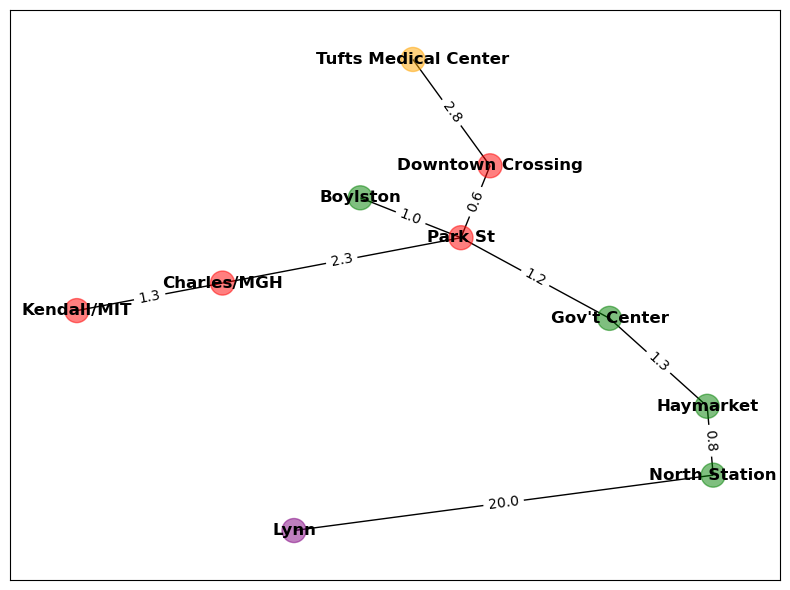

In [192]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

pos=nx.planar_layout(min_g)
pos=nx.spring_layout(min_g, pos=pos, weight="inv_weight")

nx.draw_networkx_nodes(
    min_g,
    pos=pos,
    nodelist=node_list,
    node_color=node_colors,
    alpha=0.5,
    ax=ax
)
nx.draw_networkx_edges(min_g, pos, ax=ax)
nx.draw_networkx_labels(
    min_g,
    pos=pos,
    labels=node_names,
    font_size=12,
    font_weight="bold",
    ax=ax
)
_ = nx.draw_networkx_edge_labels(
    min_g,
    pos=pos,
    edge_labels=edge_times,
    ax=ax
)



plt.tight_layout()
plt.savefig("station_times_example.png", dpi=600)